이상치 제거: X, Sampling: X, model: Catboost

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib import font_manager, rc
from scipy import stats

plt.rcParams.update({'font.family' : 'Malgun Gothic'}) # 맑은 고딕 설정
plt.rcParams.update({'axes.unicode_minus' : False}) # 음수 기호 깨짐 방지

# 데이터 불러오기
raw_df = pd.read_csv("../bigfile/data_week4.csv", encoding='cp949')
df = raw_df.copy()

# 자료형 변경
df['mold_code'] = df['mold_code'].astype('object')
df['registration_time'] = pd.to_datetime(df['registration_time'])
df['passorfail'] = df['passorfail'].astype('bool')

# 시간 변수 추가
df['hour'] = df['registration_time'].dt.hour
df['minute'] = df['registration_time'].dt.minute
df['second'] = df['registration_time'].dt.second

# 타겟변수에 있는 결측치 1개 제거하기
df.dropna(subset=['passorfail'], inplace=True)

# 불필요한 컬럼 제거
df = df.drop(['Unnamed: 0', 'line', 'name', 'mold_name', 'emergency_stop', 'time', 'date'], axis=1)


# -------------------------------------------- 새로운 데이터 프레임.
# tryshot_signal == nan 일 때만, df2로 만들기
df2 = df[df['tryshot_signal'].isna()]
df2 = df2.drop('tryshot_signal', axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_8292\663396210.py:13: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("../bigfile/data_week4.csv", encoding='cp949')


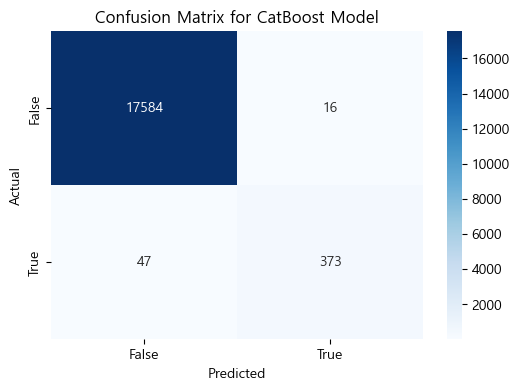

Precision: 0.9589
Recall: 0.8881
F1-Score: 0.9221
ROC-AUC: 0.9946
G-Mean: 0.9420


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from catboost import CatBoostClassifier
from imblearn.metrics import geometric_mean_score

# 종속 변수와 독립 변수 설정
X = df2.drop(columns=['passorfail'])
y = df2['passorfail']

# 범주형 변수를 one-hot encoding
X = pd.get_dummies(X)

# 데이터셋 분할 (훈련셋 80%, 테스트셋 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CatBoost 모델 학습
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# 예측
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]  # ROC-AUC에 사용할 확률 예측

# 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()

# 성능 지표 계산
report = classification_report(y_test, y_pred_catboost, output_dict=True)
precision = report['True']['precision']
recall = report['True']['recall']
f1 = f1_score(y_test, y_pred_catboost)
roc_auc = roc_auc_score(y_test, y_pred_proba)
g_mean = geometric_mean_score(y_test, y_pred_catboost)

# 결과 출력
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"G-Mean: {g_mean:.4f}")

전체 변수 중요도:
                         Feature  Importance
7                  cast_pressure   17.802250
15            sleeve_temperature    8.759628
12              lower_mold_temp1    7.078828
13              lower_mold_temp2    7.034849
10              upper_mold_temp2    5.930133
19             registration_time    5.915677
9               upper_mold_temp1    5.810379
6                  molten_volume    4.084061
16             physical_strength    3.868090
5             high_section_speed    3.693581
0                          count    3.524946
2   facility_operation_cycleTime    3.224112
18            EMS_operation_time    2.593130
25                mold_code_8412    2.587915
8              biscuit_thickness    2.472467
20                          hour    2.459661
30                mold_code_8722    2.205070
21                        minute    2.179917
4              low_section_speed    1.762544
22                        second    1.386873
1                    molten_temp    1.352233

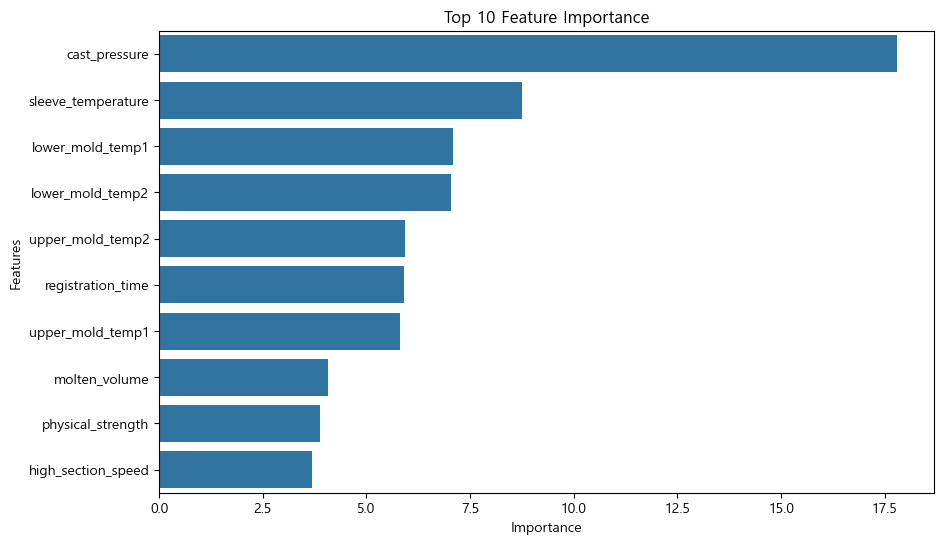


Top 10 변수 중요도:
               Feature  Importance
7        cast_pressure   17.802250
15  sleeve_temperature    8.759628
12    lower_mold_temp1    7.078828
13    lower_mold_temp2    7.034849
10    upper_mold_temp2    5.930133
19   registration_time    5.915677
9     upper_mold_temp1    5.810379
6        molten_volume    4.084061
16   physical_strength    3.868090
5   high_section_speed    3.693581


In [21]:
##  변수 중요도 확인
# 변수 중요도 계산
feature_importances = catboost_model.get_feature_importance()
features = X.columns

# 변수 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# 중요도 높은 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 전체 변수 중요도 출력
print("전체 변수 중요도:")
print(feature_importance_df)

# 변수 중요도 시각화 (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Top 10 변수 중요도 출력
print("\nTop 10 변수 중요도:")
print(feature_importance_df.head(10))

이상치 제거: O(고민해보기 다 넣은 것), Sampling: X, model: Catboost

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib import font_manager, rc
from scipy import stats

plt.rcParams.update({'font.family' : 'Malgun Gothic'}) # 맑은 고딕 설정
plt.rcParams.update({'axes.unicode_minus' : False}) # 음수 기호 깨짐 방지

# 데이터 불러오기
raw_df = pd.read_csv("../bigfile/data_week4.csv", encoding='cp949')
df = raw_df.copy()

# 자료형 변경
df['mold_code'] = df['mold_code'].astype('object')
df['registration_time'] = pd.to_datetime(df['registration_time'])
df['passorfail'] = df['passorfail'].astype('bool')

# 시간 변수 추가
df['hour'] = df['registration_time'].dt.hour
df['minute'] = df['registration_time'].dt.minute
df['second'] = df['registration_time'].dt.second

# 타겟변수에 있는 결측치 1개 제거하기
df.dropna(subset=['passorfail'], inplace=True)

# 불필요한 컬럼 제거
df = df.drop(['Unnamed: 0', 'line', 'name', 'mold_name', 'emergency_stop', 'time', 'date'], axis=1)


# -------------------------------------------- 새로운 데이터 프레임.
# tryshot_signal == nan 일 때만, df2로 만들기
df2 = df[df['tryshot_signal'].isna()]
df2 = df2.drop('tryshot_signal', axis=1)

# --------------------------------------------- 이상치 제거
df2 = df2[(df2['physical_strength'] < 60000)&(df2['low_section_speed'] < 60000) & (df2['lower_mold_temp3'] < 60000)]
df2 = df2[df2['upper_mold_temp1']<1000]  # 고민해보기
df2 = df2[df2['upper_mold_temp2']<4000]  # 고민해보기

C:\Users\USER\AppData\Local\Temp\ipykernel_8292\1324797251.py:13: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("../bigfile/data_week4.csv", encoding='cp949')


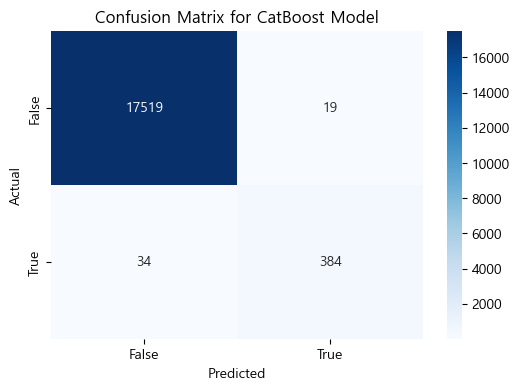

Precision: 0.9529
Recall: 0.9187
F1-Score: 0.9354
ROC-AUC: 0.9989
G-Mean: 0.9579


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from catboost import CatBoostClassifier
from imblearn.metrics import geometric_mean_score

# 종속 변수와 독립 변수 설정
X = df2.drop(columns=['passorfail'])
y = df2['passorfail']

# 범주형 변수를 one-hot encoding
X = pd.get_dummies(X)

# 데이터셋 분할 (훈련셋 80%, 테스트셋 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CatBoost 모델 학습
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# 예측
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]  # ROC-AUC에 사용할 확률 예측

# 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()

# 성능 지표 계산
report = classification_report(y_test, y_pred_catboost, output_dict=True)
precision = report['True']['precision']
recall = report['True']['recall']
f1 = f1_score(y_test, y_pred_catboost)
roc_auc = roc_auc_score(y_test, y_pred_proba)
g_mean = geometric_mean_score(y_test, y_pred_catboost)

# 결과 출력
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"G-Mean: {g_mean:.4f}")

전체 변수 중요도:
                         Feature  Importance
7                  cast_pressure   16.783782
15            sleeve_temperature    9.304824
12              lower_mold_temp1    7.422144
10              upper_mold_temp2    6.446197
13              lower_mold_temp2    6.216682
9               upper_mold_temp1    6.051181
19             registration_time    5.312060
16             physical_strength    4.701016
0                          count    4.202173
2   facility_operation_cycleTime    3.877154
8              biscuit_thickness    3.833217
5             high_section_speed    3.143426
18            EMS_operation_time    2.812437
6                  molten_volume    2.439641
21                        minute    2.338494
1                    molten_temp    1.990899
4              low_section_speed    1.792162
30                mold_code_8722    1.773127
22                        second    1.754020
20                          hour    1.704395
3           production_cycletime    1.456762

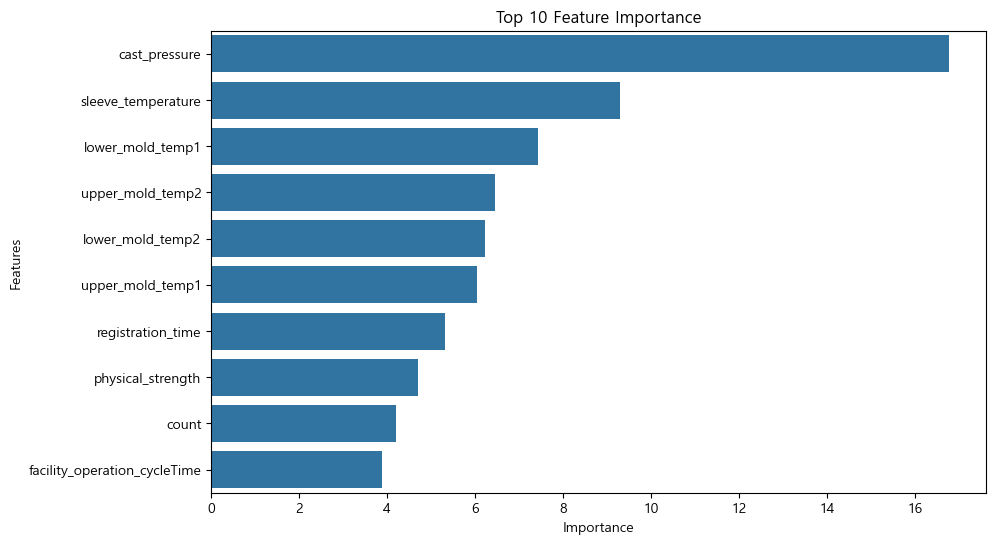


Top 10 변수 중요도:
                         Feature  Importance
7                  cast_pressure   16.783782
15            sleeve_temperature    9.304824
12              lower_mold_temp1    7.422144
10              upper_mold_temp2    6.446197
13              lower_mold_temp2    6.216682
9               upper_mold_temp1    6.051181
19             registration_time    5.312060
16             physical_strength    4.701016
0                          count    4.202173
2   facility_operation_cycleTime    3.877154


In [24]:
##  변수 중요도 확인
# 변수 중요도 계산
feature_importances = catboost_model.get_feature_importance()
features = X.columns

# 변수 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# 중요도 높은 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 전체 변수 중요도 출력
print("전체 변수 중요도:")
print(feature_importance_df)

# 변수 중요도 시각화 (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Top 10 변수 중요도 출력
print("\nTop 10 변수 중요도:")
print(feature_importance_df.head(10))

이상치 제거: O(고민해보기 다 넣은 것), 파생변수 O, Sampling: X, model: Catboost

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib import font_manager, rc
from scipy import stats

plt.rcParams.update({'font.family' : 'Malgun Gothic'}) # 맑은 고딕 설정
plt.rcParams.update({'axes.unicode_minus' : False}) # 음수 기호 깨짐 방지

# 데이터 불러오기
raw_df = pd.read_csv("../bigfile/data_week4.csv", encoding='cp949')
df = raw_df.copy()

# 자료형 변경
df['mold_code'] = df['mold_code'].astype('object')
df['registration_time'] = pd.to_datetime(df['registration_time'])
df['passorfail'] = df['passorfail'].astype('bool')

# 시간 변수 추가
df['hour'] = df['registration_time'].dt.hour
df['minute'] = df['registration_time'].dt.minute
df['second'] = df['registration_time'].dt.second

# 타겟변수에 있는 결측치 1개 제거하기
df.dropna(subset=['passorfail'], inplace=True)

# 불필요한 컬럼 제거
df = df.drop(['Unnamed: 0', 'line', 'name', 'mold_name', 'emergency_stop', 'time', 'date'], axis=1)


# -------------------------------------------- 새로운 데이터 프레임.
# tryshot_signal == nan 일 때만, df2로 만들기
df2 = df[df['tryshot_signal'].isna()]
df2 = df2.drop('tryshot_signal', axis=1)

# --------------------------------------------- 이상치 제거
df2 = df2[(df2['physical_strength'] < 60000)&(df2['low_section_speed'] < 60000) & (df2['lower_mold_temp3'] < 60000)]
df2 = df2[df2['upper_mold_temp1']<1000]  # 고민해보기
df2 = df2[df2['upper_mold_temp2']<4000]  # 고민해보기

# ------------------------------------------- 파생변수
df2['molten_temp_g'] = np.where(df2['molten_temp']<600, 1,0)
df2['cast_pressure_g'] = np.where(df2['cast_pressure'] <= 270, 1, 0)
df2['biscuit_thickness_g'] = np.where((df2['biscuit_thickness']>60) |(df2['biscuit_thickness']<20), 1,0 )
df2['physical_strength_g'] = np.where(df2['physical_strength'] < 500, 1, 0)
df2['low_section_speed_g'] = np.where(df2['low_section_speed'] < 75, 1, 0)
df2['high_section_speed_g'] = np.where((df2['high_section_speed'] >200)|(df2['high_section_speed'] < 70), 1, 0)

C:\Users\USER\AppData\Local\Temp\ipykernel_8292\2192765521.py:13: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("../bigfile/data_week4.csv", encoding='cp949')


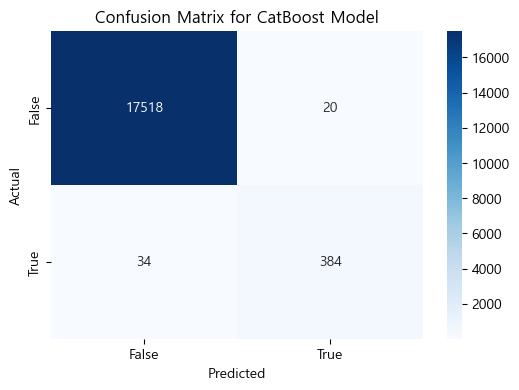

Precision: 0.9505
Recall: 0.9187
F1-Score: 0.9343
ROC-AUC: 0.9989
G-Mean: 0.9579


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from catboost import CatBoostClassifier
from imblearn.metrics import geometric_mean_score

# 종속 변수와 독립 변수 설정
X = df2.drop(columns=['passorfail'])
y = df2['passorfail']

# 범주형 변수를 one-hot encoding
X = pd.get_dummies(X)

# 데이터셋 분할 (훈련셋 80%, 테스트셋 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CatBoost 모델 학습
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# 예측
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]  # ROC-AUC에 사용할 확률 예측

# 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()

# 성능 지표 계산
report = classification_report(y_test, y_pred_catboost, output_dict=True)
precision = report['True']['precision']
recall = report['True']['recall']
f1 = f1_score(y_test, y_pred_catboost)
roc_auc = roc_auc_score(y_test, y_pred_proba)
g_mean = geometric_mean_score(y_test, y_pred_catboost)

# 결과 출력
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"G-Mean: {g_mean:.4f}")

전체 변수 중요도:
                         Feature  Importance
7                  cast_pressure    8.953791
15            sleeve_temperature    8.926528
12              lower_mold_temp1    8.362496
24               cast_pressure_g    7.815684
10              upper_mold_temp2    7.019004
19             registration_time    6.416990
13              lower_mold_temp2    6.041391
9               upper_mold_temp1    5.921353
8              biscuit_thickness    4.223440
16             physical_strength    3.806317
0                          count    3.766083
2   facility_operation_cycleTime    3.650489
21                        minute    2.944072
1                    molten_temp    2.600635
36                mold_code_8722    2.274465
5             high_section_speed    2.158071
31                mold_code_8412    2.034953
6                  molten_volume    1.837381
3           production_cycletime    1.656004
20                          hour    1.521302
4              low_section_speed    1.404446

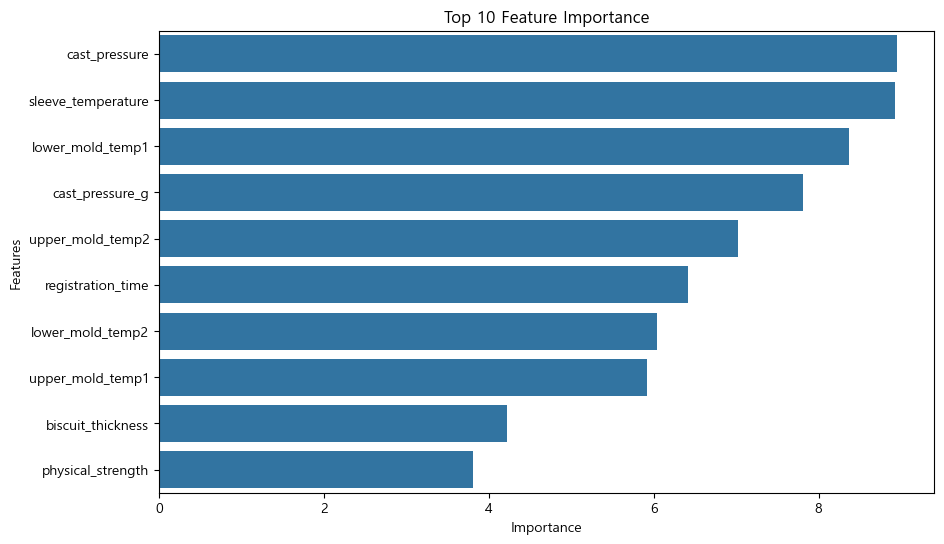


Top 10 변수 중요도:
               Feature  Importance
7        cast_pressure    8.953791
15  sleeve_temperature    8.926528
12    lower_mold_temp1    8.362496
24     cast_pressure_g    7.815684
10    upper_mold_temp2    7.019004
19   registration_time    6.416990
13    lower_mold_temp2    6.041391
9     upper_mold_temp1    5.921353
8    biscuit_thickness    4.223440
16   physical_strength    3.806317


In [27]:
##  변수 중요도 확인
# 변수 중요도 계산
feature_importances = catboost_model.get_feature_importance()
features = X.columns

# 변수 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# 중요도 높은 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 전체 변수 중요도 출력
print("전체 변수 중요도:")
print(feature_importance_df)

# 변수 중요도 시각화 (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Top 10 변수 중요도 출력
print("\nTop 10 변수 중요도:")
print(feature_importance_df.head(10))

이상치 파생변수 O 
이상치 제거: O(고민해보기 다 넣은 것), 파생변수 O (+ 이상치 파생변수 O), Sampling: X, model: Catboost

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib import font_manager, rc
from scipy import stats

plt.rcParams.update({'font.family' : 'Malgun Gothic'}) # 맑은 고딕 설정
plt.rcParams.update({'axes.unicode_minus' : False}) # 음수 기호 깨짐 방지

# 데이터 불러오기
raw_df = pd.read_csv("../bigfile/data_week4.csv", encoding='cp949')
df = raw_df.copy()

# 자료형 변경
df['mold_code'] = df['mold_code'].astype('object')
df['registration_time'] = pd.to_datetime(df['registration_time'])

# 시간 변수 추가
df['hour'] = df['registration_time'].dt.hour
df['minute'] = df['registration_time'].dt.minute
df['second'] = df['registration_time'].dt.second
df['month'] = df['registration_time'].dt.month
df['day'] = df['registration_time'].dt.day

# 타겟변수에 있는 결측치 1개 제거하기
df.dropna(subset=['passorfail'], inplace=True)

# 불필요한 컬럼 제거
df = df.drop(['Unnamed: 0', 'line', 'name', 'mold_name', 'emergency_stop', 'time', 'date'], axis=1)


# -------------------------------------------- 새로운 데이터 프레임.
# tryshot_signal == nan 일 때만, df2로 만들기
df2 = df[df['tryshot_signal'].isna()]
df2 = df2.drop('tryshot_signal', axis=1)

# --------------------------------------------- 이상치 제거
df2 = df2[(df2['physical_strength'] < 60000)&(df2['low_section_speed'] < 60000) & (df2['lower_mold_temp3'] < 60000)]
df2 = df2[df2['upper_mold_temp1']<1000]  # 고민해보기
df2 = df2[df2['upper_mold_temp2']<4000]  # 고민해보기

# ------------------------------------------- 파생변수
df2['molten_temp_g'] = np.where(df2['molten_temp']<600, 1,0)
df2['cast_pressure_g'] = np.where(df2['cast_pressure'] <= 270, 1, 0)
df2['biscuit_thickness_g'] = np.where((df2['biscuit_thickness']>60) |(df2['biscuit_thickness']<20), 1,0 )
df2['physical_strength_g'] = np.where(df2['physical_strength'] < 500, 1, 0)
df2['low_section_speed_g'] = np.where(df2['low_section_speed'] < 75, 1, 0)
df2['high_section_speed_g'] = np.where((df2['high_section_speed'] >200)|(df2['high_section_speed'] < 70), 1, 0)


# -------------------------------------------- 모델 돌리기 전 과정
# 종속 변수와 독립 변수 설정
X = df2.drop(columns=['passorfail'])
y = df2['passorfail']

# 범주형 변수를 one-hot encoding
X = pd.get_dummies(X)

# 데이터셋 분할 (훈련셋 80%, 테스트셋 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# -------------------------------------------- 이상치 파생변수

# 이상치 여부 컬럼 만들기
def IQR_outlier(data) :
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR) 
    upper_bound = Q3 + (1.5 * IQR)
    out_df = pd.concat([lower_bound, upper_bound], axis = 1).T
    out_df.index = ['하한','상한']
    return out_df

num_X_train = X_train.select_dtypes(include=('number'))

for col in num_X_train.columns:
	X_train[f'{col}_outlier'] = np.where((X_train[col]<IQR_outlier(num_X_train).loc['하한',col])|(X_train[col]>IQR_outlier(num_X_train).loc['상한',col]),True,False)
	X_test[f'{col}_outlier'] = np.where((X_test[col]<IQR_outlier(num_X_train).loc['하한',col])|(X_test[col]>IQR_outlier(num_X_train).loc['상한',col]),True,False)

C:\Users\USER\AppData\Local\Temp\ipykernel_8292\2380424661.py:13: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("../bigfile/data_week4.csv", encoding='cp949')


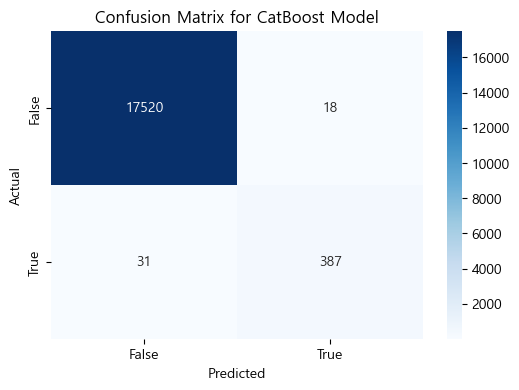

KeyError: 'True'

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from catboost import CatBoostClassifier
from imblearn.metrics import geometric_mean_score

# CatBoost 모델 학습
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# 예측
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]  # ROC-AUC에 사용할 확률 예측

# 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()

# 성능 지표 계산
report = classification_report(y_test, y_pred_catboost, output_dict=True)
precision = report['True']['precision']
recall = report['True']['recall']
f1 = f1_score(y_test, y_pred_catboost)
roc_auc = roc_auc_score(y_test, y_pred_proba)
g_mean = geometric_mean_score(y_test, y_pred_catboost)

# 결과 출력
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"G-Mean: {g_mean:.4f}")


전체 변수 중요도:
                         Feature  Importance
7                  cast_pressure    8.953791
15            sleeve_temperature    8.926528
12              lower_mold_temp1    8.362496
24               cast_pressure_g    7.815684
10              upper_mold_temp2    7.019004
19             registration_time    6.416990
13              lower_mold_temp2    6.041391
9               upper_mold_temp1    5.921353
8              biscuit_thickness    4.223440
16             physical_strength    3.806317
0                          count    3.766083
2   facility_operation_cycleTime    3.650489
21                        minute    2.944072
1                    molten_temp    2.600635
36                mold_code_8722    2.274465
5             high_section_speed    2.158071
31                mold_code_8412    2.034953
6                  molten_volume    1.837381
3           production_cycletime    1.656004
20                          hour    1.521302
4              low_section_speed    1.404446

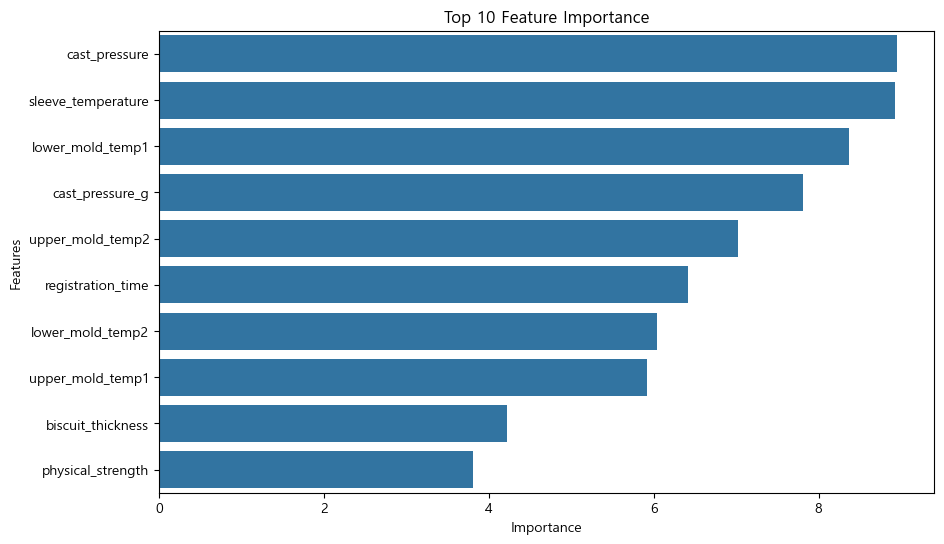


Top 10 변수 중요도:
               Feature  Importance
7        cast_pressure    8.953791
15  sleeve_temperature    8.926528
12    lower_mold_temp1    8.362496
24     cast_pressure_g    7.815684
10    upper_mold_temp2    7.019004
19   registration_time    6.416990
13    lower_mold_temp2    6.041391
9     upper_mold_temp1    5.921353
8    biscuit_thickness    4.223440
16   physical_strength    3.806317


In [32]:
##  변수 중요도 확인
# 변수 중요도 계산
feature_importances = catboost_model.get_feature_importance()
features = X.columns

# 변수 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# 중요도 높은 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 전체 변수 중요도 출력
print("전체 변수 중요도:")
print(feature_importance_df)

# 변수 중요도 시각화 (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Top 10 변수 중요도 출력
print("\nTop 10 변수 중요도:")
print(feature_importance_df.head(10))